## Scikit-ribo manuscript analysis 

In [1]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, spearmanr, ttest_ind, levene, f_oneway, ttest_1samp, skewtest
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import csv
from statsmodels import robust
import matplotlib.gridspec as gridspec
from statsmodels.formula.api import ols
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True, font_scale=2)
snsRed, snsBlue, snsGreen, snsPurple, snsOrange = sns.color_palette("Set1", n_colors=5, desat=.5)
snsGray = sns.color_palette("Set1", n_colors=9, desat=.5)[8]

### Define data locations

In [2]:
protein_quant = "../Data/Lawless_2016.csv.cleaned.csv"
protein_degradation = "../Data/Christiano_2014.csv.cleaned.csv"
rna_halflife = "../Data/Geisberg_2014.csv.cleaned.csv"
kallisto_ribo = "../Data/kallisto_riboseq_abundance.tsv"
kallisto_rna = "../Data/kallisto_rnaseq_abundance.tsv"
skr_weinberg = "../Data/skr_weinberg_genesTE.csv"
skr_codon = "../Data/skr_weinberg_codons.csv"

sgdGene_bed = "../Data/Yeast.sacCer3.sgdGene.cds.bed"
sgdGene_codons = "../Data/Yeast.sacCer3.sgdGene.codons.df"
weinberg_codon = "../Data/Weinberg_2016_codon.csv"
gene_tAI = "../Data/SacCer_stAIcalc_Sabi_Tuller.txt"
tRNA_abundance = "../../Paper/Data/microarray_tRNA_abundance.csv"
codon_tAI = "../Data/tAI.csv"
codon_stAI = "../Data/Yeast_codon_stAI.csv"
model_input = "../Data/model_input.txt"

###  Import data

In [3]:
DFs = {} # a dict to save DFs
lst = [skr_weinberg, kallisto_ribo, kallisto_rna, weinberg_codon, skr_codon, codon_tAI, tRNA_abundance, 
       gene_tAI, protein_degradation, sgdGene_codons, protein_quant, rna_halflife, model_input] 
for i in lst:
    DFs[i] = pd.read_table(i, header=0)

DFs[codon_stAI] = pd.read_table(codon_stAI, header=0, sep=",")
DFs[sgdGene_bed] = pd.read_table(sgdGene_bed, sep="\t",
                                 names=['chr', 'start', 'end', 'gene', 'score', 'strand', 'thickStart',
                                        'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

In [4]:
# compute TE from rpkm
DFs[kallisto_ribo]["rpkm_ribo"] = DFs[kallisto_ribo]["est_counts"] * (10 ** 9) / (DFs[kallisto_ribo]["length"] * \
                                  np.sum(DFs[kallisto_ribo]["est_counts"]))
DFs[kallisto_rna]["rpkm_rna"] = DFs[kallisto_rna]["est_counts"] * (10 ** 9) / (DFs[kallisto_rna]["length"] * \
                                np.sum(DFs[kallisto_rna]["est_counts"]))

DFs["weinburg"] = pd.merge(DFs[kallisto_ribo], DFs[kallisto_rna], on="target_id", suffixes=["_ribo","_rna"])
DFs["weinburg"] = DFs["weinburg"][(DFs["weinburg"]["tpm_ribo"] > 0) & (DFs["weinburg"]['tpm_rna'] > 0)]
DFs["weinburg"]['log2_TE'] = np.log2(DFs["weinburg"]["rpkm_ribo"] / DFs["weinburg"]["rpkm_rna"])
DFs["weinburg"]["log2_TE"] = (DFs["weinburg"]["log2_TE"] - np.median(DFs["weinburg"]["log2_TE"])) / np.log(2)
# save to dict
DFs["RPKM"] = DFs["weinburg"].copy()
DFs["scikit-ribo"] = DFs[skr_weinberg].copy()

### 1. TE comparsion: scikit-ribo vs. rpkm

#### (1) RPKM derived log(TE) was negatively skewed, whike scikit-ribo reported balanced distribution

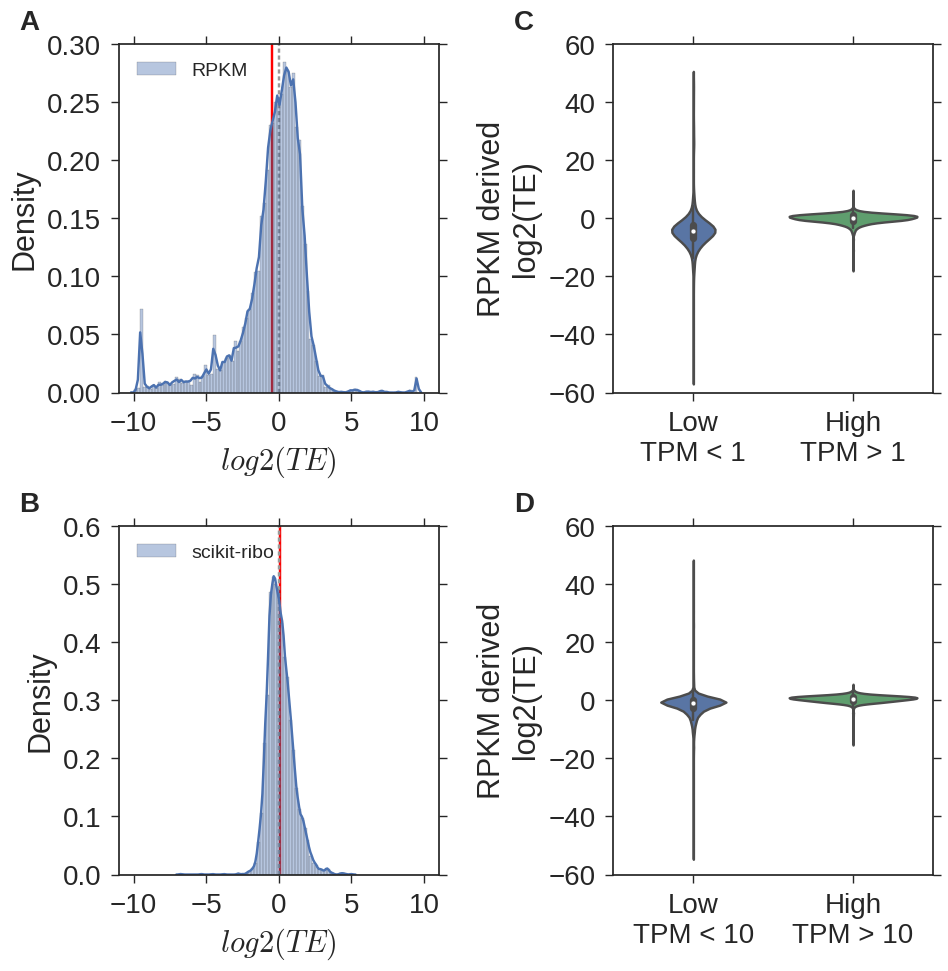

In [5]:
fig = plt.figure(figsize=(10, 10))
subplotOrder = [1, 3, 2, 4]

samples = ('RPKM', 'scikit-ribo')
shared_bins=np.linspace(-20, 20, 200)
for i, label in enumerate(('A', 'B')):
    sample = samples[i]
    idx = subplotOrder[i]
    ax = plt.subplot(2, 2, idx)
    tmp = DFs[sample].copy()
    mean_log2_TE = np.mean(tmp['log2_TE'])
    tmp['log2_TE'] = np.where(tmp['log2_TE'] < -10, -9.5, tmp['log2_TE'])
    tmp['log2_TE'] = np.where(tmp['log2_TE'] > 10, 9.5, tmp['log2_TE'])
    ax = sns.distplot(tmp['log2_TE'], label=sample,
                       bins=shared_bins, kde_kws={"bw":0.1})
    ax.set(xlim=(-11, 11))
    ax.axvline(mean_log2_TE, color="red", zorder=-1)
    ax.axvline(0, color="#999999", dashes=[3,2], zorder=-1)
    ax.text(-0.25, 1.1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')  
    ax.legend(fontsize=14, loc=2)
    ax.set_xlabel('$log2(TE)$')
    ax.set_ylabel('Density')    

TPM_cutoffs = [1, 10]
for i, label in enumerate(('C', 'D')):
    idx = subplotOrder[i+2]
    cutoff = TPM_cutoffs[i]
    tmp = DFs["RPKM"].copy()
    tmp["abundance"] = np.where((tmp["tpm_ribo"] > cutoff) & (tmp["tpm_rna"] > cutoff), "High", "Low") 
    ax = plt.subplot(2, 2, idx)
    ax = sns.violinplot(x="abundance", y="log2_TE", data=tmp)
    ax.set(ylim= [-60,60])
    ax.set_xticklabels(['Low\nTPM < ' + str(cutoff), 'High\nTPM > '+ str(cutoff)])
    ax.set_ylabel('RPKM derived\nlog2(TE)')
    ax.text(-0.25, 1.1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS1_weinburg_log2TE.pdf")
plt.show()

In [6]:
print("Mean of log2(TE)")
for i, label in enumerate(('A', 'B')):
    sample = samples[i]
    print(sample, ":", np.mean(DFs[sample]['log2_TE']))

Mean of log2(TE)
RPKM : -0.481474304907841
scikit-ribo : 0.1127988253719658


#### (2) Low abundance genes' TEs have high dispersion 

In [7]:
cutoff = 10
DFs["RPKM"]["abundance"] = np.where((DFs["RPKM"]["tpm_ribo"] > cutoff) & (DFs["RPKM"]["tpm_rna"] > cutoff), 
                                    "High", "Low") 
low_abundance_log2_TE = DFs["RPKM"][DFs["RPKM"]["abundance"]=="Low"]["log2_TE"]
high_abundance_log2_TE = DFs["RPKM"][DFs["RPKM"]["abundance"]=="High"]["log2_TE"]
levene_test_variance = levene(low_abundance_log2_TE, high_abundance_log2_TE)
print("Levene test of equal variance, p-value:", levene_test_variance[1])
print("Ratio of s.d.:", np.std(low_abundance_log2_TE) / np.std(high_abundance_log2_TE))

low_abundance_range = np.ptp(low_abundance_log2_TE)
high_abundance_range = np.ptp(high_abundance_log2_TE)
print("Ranges of log2(TE)", low_abundance_range, high_abundance_range)
print("Ratio of log2(TE) ranges:", low_abundance_range / high_abundance_range)

print("MAD of low abundance :", robust.mad(low_abundance_log2_TE))
print("MAD of high abundance :", robust.mad(high_abundance_log2_TE))

Levene test of equal variance, p-value: 3.38660609072e-89
Ratio of s.d.: 3.0361791942753382
Ranges of log2(TE) 99.7252369717 19.8455113934
Ratio of log2(TE) ranges: 5.02507771127
MAD of low abundance : 1.88449207871
MAD of high abundance : 1.00900706659


#### (3) Scikit-ribo quality control step removed extremely low abundance genes

In [8]:
# combine data
DFs["TE"] = pd.merge(DFs["scikit-ribo"], DFs["RPKM"], left_on=["gene"], right_on=["target_id"], 
                     suffixes=["_skr","_rpkm"])
DFs["excluded"] = pd.merge(DFs["RPKM"], DFs["scikit-ribo"], left_on=["target_id"], right_on=["gene"], 
                           suffixes=["_rpkm","_skr"], how="left")
DFs["excluded"]["category"] = np.where(DFs["excluded"]["gene"].isnull(), "Excluded", "Included") 

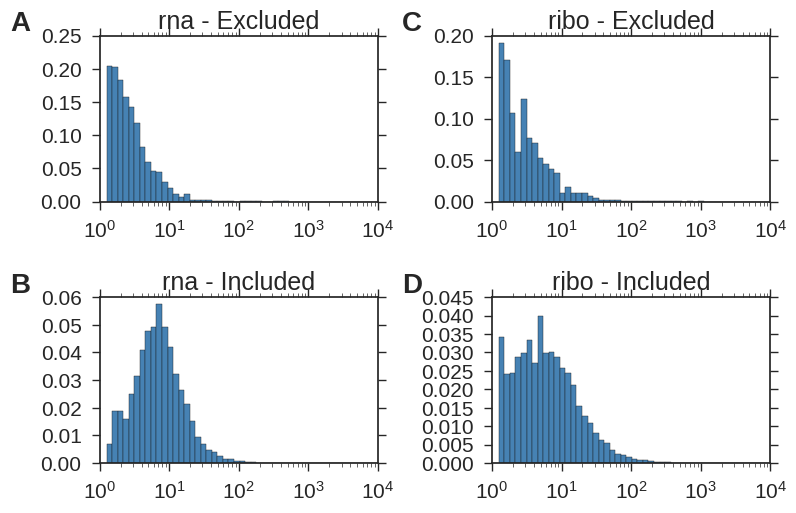

In [9]:
sns.set(style="ticks", color_codes=True, font_scale=1.5)
bins=np.logspace(0.1, 4.0, 50)
categories = ["Excluded", "Included"]

for i, label in enumerate(('A', 'B')):
    library = "rna"
    idx = subplotOrder[i]
    category = categories[i]
    ax = plt.subplot(2, 2, idx)
    ax.set_title(library + " - " +  category)
    tmp = DFs["excluded"].copy()
    ax.hist(tmp[tmp["category"]==category]["tpm_" + library], color="steelblue", bins=bins, normed=True)
    ax.set_xscale('log')
    ax.text(-0.25, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    plt.tight_layout()

for i, label in enumerate(('C', 'D')):
    library = "ribo"
    idx = subplotOrder[i+2]
    category = categories[i]
    ax = plt.subplot(2, 2, idx)
    ax.set_title(library + " - " + category)
    tmp = DFs["excluded"].copy()
    ax.hist(tmp[tmp["category"]==category]["tpm_" + library], color="steelblue", bins=bins, normed=True)
    ax.set_xscale('log')
    ax.text(-0.25, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    plt.tight_layout()

plt.savefig("../Figures/Supplemental/FigureS2_weinburg_scikit-ribo_qc_tpm.pdf")
sns.set(style="ticks", color_codes=True, font_scale=2)

### 2. codon elongation rates and mRNA secondary structure

#### 1) mRNA secondary structure

In [10]:
DFs["codons"] = pd.merge(DFs[skr_codon], DFs[weinberg_codon], on="codon")
DFs["codons"] = pd.merge(DFs["codons"], DFs[codon_tAI], on="codon")
DFs["codons"] = pd.merge(DFs["codons"], DFs[tRNA_abundance], on="codon")

DFs["codons"]["codon_ER"] = 1 / DFs["codons"]["codon_dwell_time"]
DFs["codons"]["tRNA_abundance"] = DFs["codons"]["tRNA_abundance"] * 100 / np.sum(DFs["codons"]["tRNA_abundance"])

In [11]:
# pre-process
ribo = DFs[model_input][["gene","codon", "codon_idx", "ribosome_count", "pair_prob", "TPM", "gene_strand"]]
geneLenInCodon = ribo[["gene", "codon"]].groupby(["gene"]).size().reset_index(name="numCodons")
geneLenInCodon["numCodons"] = geneLenInCodon["numCodons"] - 16 # exclude the flanking UTR regions
ribo = pd.merge(ribo, geneLenInCodon, on="gene")
ribo = ribo[(ribo["codon_idx"] > 0) & (ribo["codon_idx"] < ribo["numCodons"] - 1)] # exclude start and stop codons
ribo = ribo[((ribo["codon"] != 'TAG') & (ribo["codon"] != 'TAA') & (ribo["codon"] != 'TGA'))]
ribo = ribo[(ribo["TPM"] > 1)]
riboCov = ribo[ribo["ribosome_count"] > 0][["gene", "ribosome_count"]].groupby(["gene"]).mean().reset_index()
riboCov.rename(columns={"ribosome_count":"avg_count"}, inplace=True)
ribo = pd.merge(ribo, riboCov, on=["gene"], how="left")
ribo = ribo[ribo["avg_count"] >= 1]
# scale by the mean and codon dwell time
ribo["norm_count"] = ribo["ribosome_count"] / ribo["avg_count"]
ribo = pd.merge(ribo, DFs["codons"], on="codon", how="left")
ribo["norm_count_adjusted"] = ribo["norm_count"] / ribo["codon_dwell_time"]
# stem loops in the inner region of ORF
inner_stem_loop = ribo[(ribo["pair_prob"] == 1.0) & 
                       (ribo["codon_idx"] > 100) & 
                       (ribo["codon_idx"] < ribo["numCodons"]-100)]
stem_loop_idx = inner_stem_loop.index
# print(stem_loop_inner.shape)
# given window size, find the relative scaled dwell time
window_size = 60
leg_size = int(window_size / 2)
norm_count_adjusted_lst = []
for idx in stem_loop_idx:
    if ribo.loc[idx, "gene_strand"] == "+":
        norm_count_adjusted_lst.append(list(ribo.loc[idx-leg_size: idx+leg_size, "norm_count_adjusted"]))
    elif ribo.loc[idx, "gene_strand"] == "-":
        norm_count_adjusted_lst.append(list(ribo.loc[idx-leg_size: idx+leg_size, "norm_count_adjusted"])[::-1])
# mean normalized the relative scaled dwell time
avg_norm_count_adjusted = np.mean(np.array(norm_count_adjusted_lst), axis=0)
avg_norm_count_adjusted = np.log2( avg_norm_count_adjusted / np.mean(avg_norm_count_adjusted))
windown_pvalue = ttest_ind(avg_norm_count_adjusted[0:leg_size], avg_norm_count_adjusted[leg_size+1:window_size+1])#[1]
print("p-value comparing left with right:" , windown_pvalue)

p-value comparing left with right: Ttest_indResult(statistic=2.9334607507963608, pvalue=0.0047938277726368205)


In [12]:
codon_corr = round(pearsonr(DFs["codons"]["Weinberg_dwell_time"], DFs["codons"]["codon_dwell_time"])[0], 2)
tAI_corr   = round(spearmanr(DFs["codons"]["tAI"], DFs["codons"]["codon_ER"])[0], 2)
tRNA_corr  = round(spearmanr(DFs["codons"]["tRNA_abundance"], DFs["codons"]["codon_ER"])[0], 2)

codon_corrs = [tAI_corr, tRNA_corr]
print("Correlation with Weinberg et al: ", codon_corr)
print("Correlation with tAI: ", tAI_corr)
print("Correlation with tRNA abundance", tRNA_corr)

Correlation with Weinberg et al:  0.99
Correlation with tAI:  0.54
Correlation with tRNA abundance 0.47


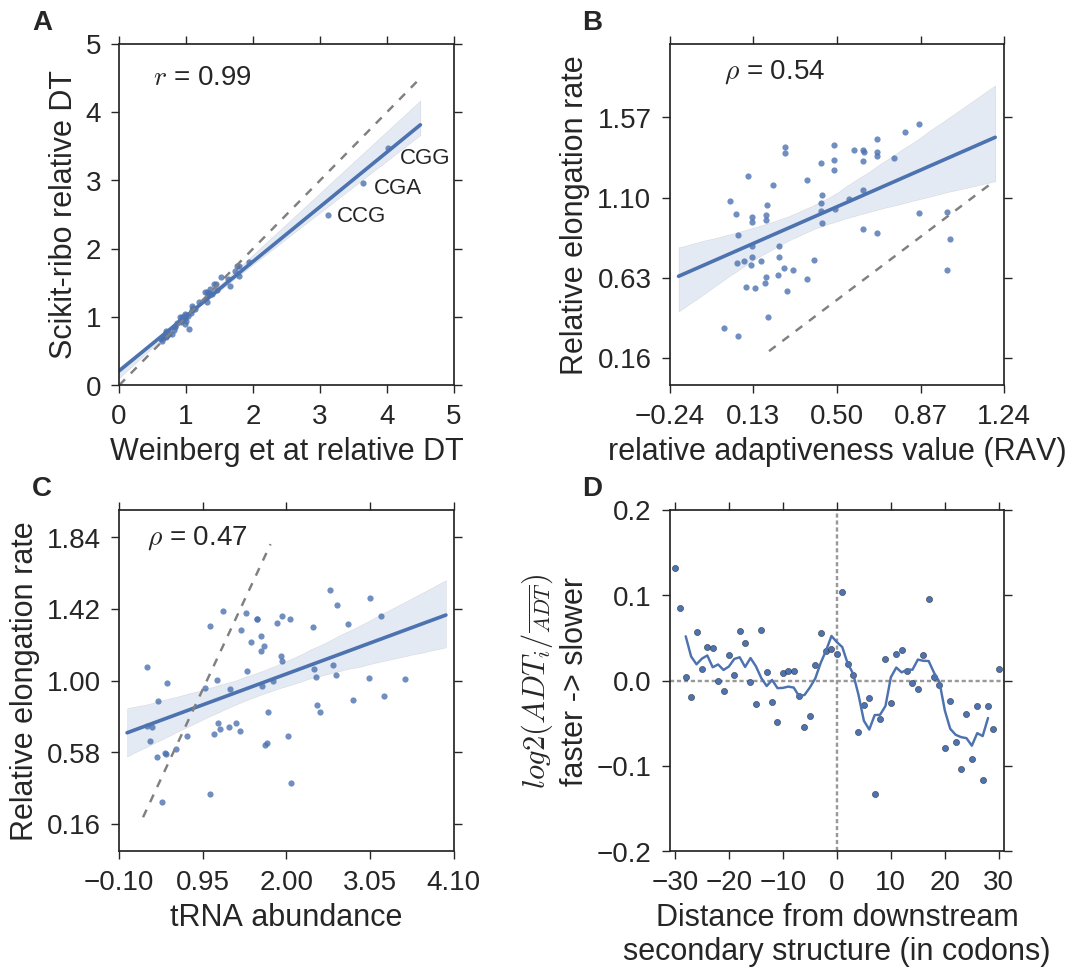

In [13]:
# plot codon rates
fig = plt.figure(figsize=(11, 10))

ax = plt.subplot(2, 2, 1)
g = sns.regplot(x="Weinberg_dwell_time", y="codon_dwell_time", data=DFs["codons"], 
                scatter_kws={"s": 20 }, ax=ax, label="label")
ax.plot([0,4.5], [0,4.5], ls="dashed", color='gray')
ax.set_ylabel('Scikit-ribo relative DT')
ax.set_xlabel("Weinberg et at relative DT")
plt.text(0.5, 4.4, r"$r$ = " + str(codon_corr), fontsize=20)
plt.text(4.2, 3.25, "CGG", fontsize=16)#,  va='top', ha='right')
plt.text(3.8, 2.8, "CGA", fontsize=16)#,  va='top', ha='right')
plt.text(3.25, 2.4, "CCG", fontsize=16)#, fontweight='bold', va='top', ha='right')
plt.text(-0.2, 1.1, "A", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax.set(xlim=(0, 4.5), ylim=(0, 4.5))
ax.set_xticks(np.linspace(0, 5.0, 6))
ax.set_yticks(np.linspace(0, 5.0, 6))

colNames = ["tAI", "tRNA_abundance"]
x_labels = ["relative adaptiveness value (RAV)", "tRNA abundance"]
for i, label in enumerate(('B', 'C')):
    ax = plt.subplot(2, 2, i+2)
    colName = colNames[i]
    g = sns.regplot(x=colName, y="codon_ER", data=DFs["codons"], scatter_kws={"s": 20}, ax=ax, label="label")
    x0, x1 = g.get_xlim()
    y0, y1 = g.get_ylim()
    x_range, y_range = (x1 - x0) * 1.05 , (y1 - y0) * 1.05
    xtick_min, xtick_max = (x1 + x0 - x_range) * 0.5, (x1 + x0 + x_range) * 0.5
    ytick_min, ytick_max = (y1 + y0 - y_range) * 0.5, (y1 + y0 + y_range) * 0.5
    xticks_new = [round(i,2) for i in (np.linspace(xtick_min, xtick_max, 5))]
    yticks_new = [round(i,2) for i in (np.linspace(ytick_min, ytick_max, 5))]
    ax.set_xticks(xticks_new)
    ax.set_yticks(yticks_new)
    lims = [max(x0, y0), min(x1, y1)]
    ax.set(ylim=(0, 2))
    ax.plot(lims, lims, ls="dashed", color='gray')
    ax.set_ylabel('Relative elongation rate')
    x_label = x_labels[i]
    ax.set_xlabel(x_label)
    ax.text(np.min(DFs["codons"][colName]), 1.8, r"$\rho$ = " + str(codon_corrs[i]), fontsize=20)
    ax.text(-0.2, 1.1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


ax = plt.subplot(2, 2, 4)

x = np.arange(-leg_size, leg_size+1, 1)
sliding_window_size = 5
window = np.ones(sliding_window_size).astype(float) / float(sliding_window_size)
sliding_window_avg = np.convolve(avg_norm_count_adjusted, window,mode="valid")
ax.scatter(x, avg_norm_count_adjusted)
ax.plot(x[2: 2*leg_size-1], sliding_window_avg, label="5 codon average")
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.axvline(0, color="#999999", dashes=[3,2],zorder=-1)
ax.axhline(0, color="#999999", dashes=[3,2],zorder=-1)
ax.set_xlabel("Distance from downstream\nsecondary structure (in codons)")
ax.set_ylabel(r"$ log2(ADT_{i} /_ \overline{ADT}) $" + "\nfaster -> slower")
plt.xlim([-leg_size-1,leg_size+1])
ax.text(-0.2, 1.1, "D", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()    
plt.savefig("../Figures/Figure3_codon_corr.pdf")

### 3. Pairwise comparisons showed that scikit-ribo:
#####     a) is robust to low abudance genes 
#####     b) corrected biases due to codon biases and secondary structure

In [14]:
# For plotting, fix any values below -10 to -10
DFs["TE"]["log2_TE_rpkm_adj"] = np.where(DFs["TE"]["log2_TE_rpkm"] < -8, -7.5, DFs["TE"]["log2_TE_rpkm"]) 
DFs["TE"]['deltaTE'] = DFs["TE"]["log2_TE_skr"] - DFs["TE"]["log2_TE_rpkm"]

In [15]:
# define regions
DFs["TE"].loc[DFs["TE"]['deltaTE'] > 0.5, 'region'] = "above"
DFs["TE"].loc[DFs["TE"]['deltaTE'] < -0.5, 'region'] = "below"
DFs["TE"].loc[(DFs["TE"]['deltaTE'] >= -0.5) & (DFs["TE"]['deltaTE'] <= 0.5), 'region'] = "middle"
# define sign of log2(TE)
DFs["TE"]["skr_sign"] = np.where(DFs["TE"]['log2_TE_skr'] > 0, "+", "-") 
DFs["TE"]["rpkm_sign"] = np.where(DFs["TE"]['log2_TE_rpkm'] > 0, "+", "-") 
# find outliers
DFs["TE"]["outlier"] = np.where(DFs["TE"]["log2_TE_rpkm"] < -8, "outlier", "not_outlier") 

In [16]:
# define colors
colors = [snsGreen, snsGray, snsOrange]
regions = ["above", "middle", "below"]

In [17]:
# stem loops
tmp = DFs[sgdGene_codons].groupby("gene").pair_prob.sum().reset_index(name="stem_loops")
tmp["stem_loops"] = tmp["stem_loops"].astype(int)
DFs["TE"] = pd.merge(DFs["TE"], tmp, on="gene")
DFs["TE"]["stem_loop_bin"] = np.where(DFs["TE"]["stem_loops"] <= 0,"0", ">=1") 
# DFs["TE"]["stem_loop_bin"] = np.where(DFs["TE"]["stem_loops"] < 4, DFs["TE"]["stem_loops"], ">=4") 

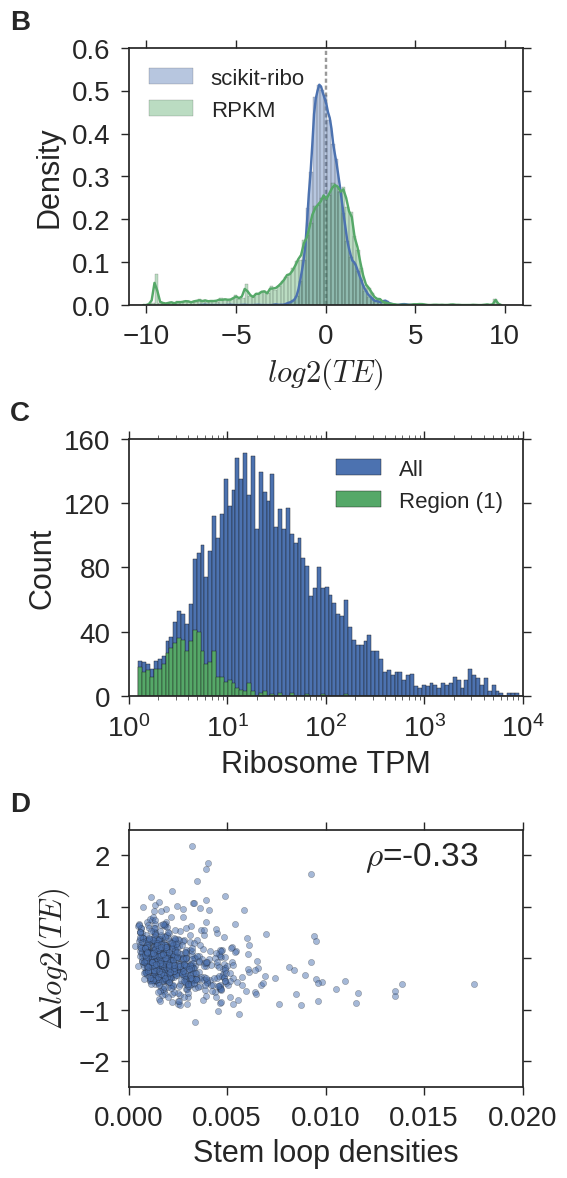

In [18]:
# plot comparisons
fig = plt.figure(figsize=(6, 12))

ax2 = plt.subplot(3, 1, 1)
samples = ('scikit-ribo', 'RPKM')
shared_bins=np.linspace(-20, 20, 200)
for sample in samples:
    tmp = DFs[sample].copy()
    tmp['log2_TE'] = np.where(tmp['log2_TE'] < -10, -9.5, tmp['log2_TE'])
    tmp['log2_TE'] = np.where(tmp['log2_TE'] > 10, 9.5, tmp['log2_TE'])
    ax2 = sns.distplot(tmp['log2_TE'], label=sample,
                       bins=shared_bins, kde_kws={"bw":0.1},
                       hist_kws={"alpha": 0.4})
    ax2.set(xlim=(-11, 11))
ax2.legend(loc=2,fontsize=16)
ax2.axvline(0, color="#999999", dashes=[3,2],zorder=-1)
ax2.set_xlabel('$log2(TE)$')
ax2.set_ylabel('Density')    
ax2.text(-0.25, 1.15, "B", transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

bins=np.logspace(0.1, 4.0, 100)
ax3 = plt.subplot(3, 1, 2)
ax3.text(-0.25, 1.15, "C", transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax3 = plt.hist(DFs["TE"]["tpm_ribo"], bins=bins, label='All')
region_one = DFs["TE"][(DFs["TE"]["region"]=="above") & (DFs["TE"]["skr_sign"]=="-")]
ax3 = plt.hist(region_one["tpm_ribo"], bins=bins, label='Region (1)')
plt.legend(fontsize=16)
plt.gca().set_yticks(range(0,200,40))
plt.gca().set_xlabel('Ribosome TPM')
plt.gca().set_ylabel('Count')
plt.gca().set_xscale("log")

ax4 = plt.subplot(3, 1, 3)
tmp = DFs["TE"][(DFs["TE"]["tpm_ribo"] > 10) & (DFs["TE"]["tpm_rna"] > 10) &
               (DFs["TE"]["stem_loops"] > 0)]
ax4.scatter(tmp["stem_loops"] * 3 / tmp["length_ribo"],  tmp["deltaTE"], alpha=0.5)
corr_sec = round(spearmanr(tmp["stem_loops"] * 3 / tmp["length_ribo"],  tmp["deltaTE"])[0] , 2)
ax4.text(-0.25, 1.15, "D", transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax4.text(0.012, 1.8, r"$\rho$=" + str(corr_sec))
ax4.set_xticks(np.arange(0, 0.025, 0.005))
ax4.set(xlim=(0, 0.02))
ax4.set(ylim=(-2.5, 2.5))
plt.gca().set_xlabel('Stem loop densities')
plt.gca().set_ylabel('$\Delta log2(TE)$')
#ax4 = sns.violinplot(x="stem_loop_bin", y="deltaTE", 
#                     data = DFs["TE"][(DFs["TE"]["tpm_ribo"] > 10) & (DFs["TE"]["tpm_rna"] > 10) & 
#                                     (DFs["TE"]["region"] == "below")],
#                     palette="muted", order=["0", ">=1"]) 
# ax4.set_yticks(range(-2,14,2))
#plt.ylabel('$\Delta log2(TE)$\nScikit-ribo vs. RPKM')
#plt.gca().set_xlabel('Stem loops')
                                      
plt.tight_layout()
plt.savefig("../Figures/Figure4BCD.pdf")

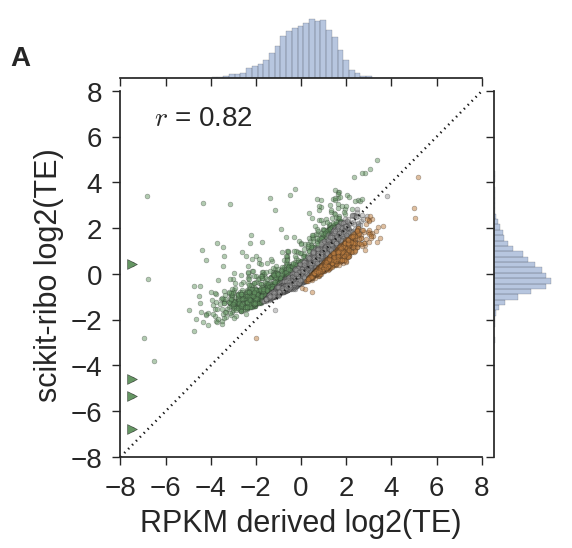

In [19]:
# compute correlation
TE_corr = round(pearsonr(DFs["TE"]["log2_TE_rpkm"], DFs["TE"]["log2_TE_skr"])[0] ,2)

g1 = sns.jointplot(x="log2_TE_rpkm_adj", y="log2_TE_skr", data=DFs["TE"], xlim= [-8,8], ylim= [-8,8], 
                   marker='.', s=50, alpha=0, stat_func=None)
g1 = (g1.set_axis_labels("RPKM derived log2(TE)", "scikit-ribo log2(TE)"))
x0, x1 = g1.ax_joint.get_xlim()
y0, y1 = g1.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.ax_joint.plot(lims, lims, ':k')

for color, region in zip(colors, regions):
    df = DFs["TE"][DFs["TE"]["region"] == region]
    g1.x, g1.y = df.log2_TE_rpkm_adj, df.log2_TE_skr
    g1.plot_joint(plt.scatter, marker='.', c=color, s=50, alpha=0.5)

g1.x = DFs["TE"][DFs["TE"]["outlier"] == "outlier"].log2_TE_rpkm_adj, 
g1.y = DFs["TE"][DFs["TE"]["outlier"] == "outlier"].log2_TE_skr
g1.plot_joint(plt.scatter, marker='>', c=snsGreen, s=50, alpha=1)

plt.text(-6.5, 6.5, r"$r$ = " + str(TE_corr), fontsize=20)
plt.text(-12, 10, "A", fontsize=20, fontweight='bold', va='top', ha='right')

plt.savefig("../Figures/Figure4A_compare_skr_rpkm_TE.pdf")

In [20]:
print(DFs["TE"].groupby("region").size())

region
above      897
below     1060
middle    3151
dtype: int64


In [21]:
print(DFs["TE"].groupby(["region","skr_sign"]).size())

region  skr_sign
above   +            268
        -            629
below   +            981
        -             79
middle  +           1305
        -           1846
dtype: int64


In [22]:
for region in ["above", "below"]:
    for sign in ["+", "-"]:
        df = DFs["TE"][(DFs["TE"]["region"]==region) & (DFs["TE"]["skr_sign"]==sign)]
        if sign == "-" and region == "above":
            partition = "1"
        elif sign == "-" and region == "below":
            partition = "3"
        elif sign == "+" and region == "above":
            partition = "4"
        elif sign == "+" and region == "below":
            partition = "6"
        df[["gene"]].to_csv(path_or_buf="../Data/genes_in_region"+ partition + ".txt", 
                            sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE)

In [23]:
# log2(TE) > 2
highTE_genes = DFs["TE"][DFs["TE"]["log2_TE_skr"] >= 2][["gene"]]
highTE_genes.to_csv(path_or_buf="../Data/highestTE_genes.csv", sep='\t', 
                    header=True, index=False, quoting=csv.QUOTE_NONE)
print(highTE_genes.shape)
# export BED to local
highTE_genes_bed = pd.merge(DFs[sgdGene_bed], highTE_genes, on="gene")
highTE_genes_bed["start_new"] = highTE_genes_bed["start"] - 50
highTE_genes_bed["end_new"] = highTE_genes_bed["start"] + 6
highTE_genes_bed = highTE_genes_bed[["chr", "start_new", "end_new", "gene", "score", "strand"]]
highTE_genes_bed.to_csv(path_or_buf="../Data/highestTE_genes.bed", sep='\t', 
                        header=False, index=False, quoting=csv.QUOTE_NONE)

(147, 1)


In [24]:
# rpkm log2(TE) > 2
rpkm_highTE_genes = DFs["TE"][DFs["TE"]["log2_TE_rpkm"] >= 2][["gene"]]
print(rpkm_highTE_genes.shape)
rpkm_highTE_genes_bed = pd.merge(DFs[sgdGene_bed], rpkm_highTE_genes, on="gene")
rpkm_highTE_genes_bed["start_new"] = rpkm_highTE_genes_bed["start"] - 50
rpkm_highTE_genes_bed["end_new"] = rpkm_highTE_genes_bed["start"] + 6
rpkm_highTE_genes_bed = rpkm_highTE_genes_bed[["chr", "start_new", "end_new", "gene", "score", "strand"]]
rpkm_highTE_genes_bed.to_csv(path_or_buf="../Data/rpkm_highestTE_genes.bed", sep='\t', 
                        header=False, index=False, quoting=csv.QUOTE_NONE)

(201, 1)


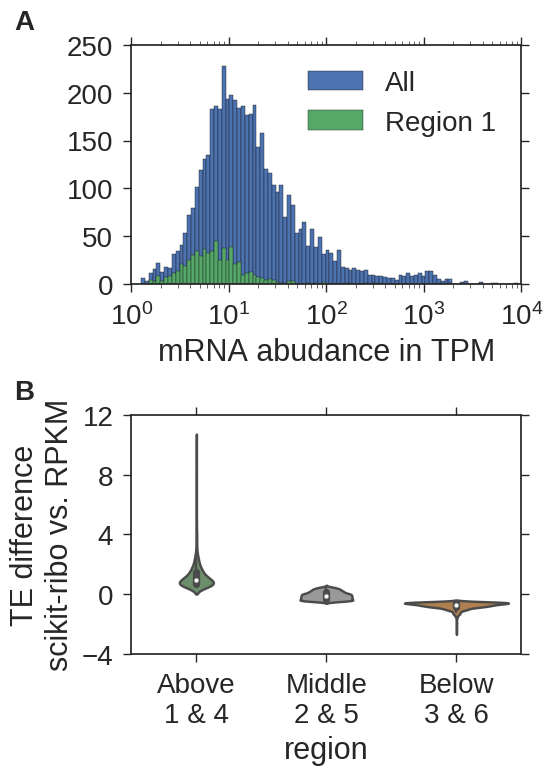

In [25]:
fig = plt.figure(figsize=(6, 8))

ax = plt.subplot(2, 1, 1)

bins=np.logspace(0.1, 4.0, 100)
ax.hist(DFs["TE"]["tpm_rna"], bins=bins, label='All')
ax.hist(region_one["tpm_rna"], bins=bins, label='Region 1')
plt.xlabel('mRNA abudance in TPM')
ax.set_xscale("log")
ax.text(-0.25, 1.15, "A", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax.legend()

# histogram mRNA abundance
ax = plt.subplot(2, 1, 2)
ax = sns.violinplot(x='region', y='deltaTE', data=DFs["TE"], palette=colors, order=regions)
ax.set_xticklabels(["Above\n1 & 4","Middle\n2 & 5", "Below\n3 & 6"])
ax.set_yticks(range(-4,16,4))
ax.text(-0.25, 1.15, "B", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.ylabel('TE difference\nscikit-ribo vs. RPKM')

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS4_upperLeft_mRNA_deltaTE_violin.pdf")

In [26]:
# get tAI & stAI
DFs["TE"] = pd.merge(DFs[gene_tAI], DFs["TE"], left_on="genes_id", right_on="gene")


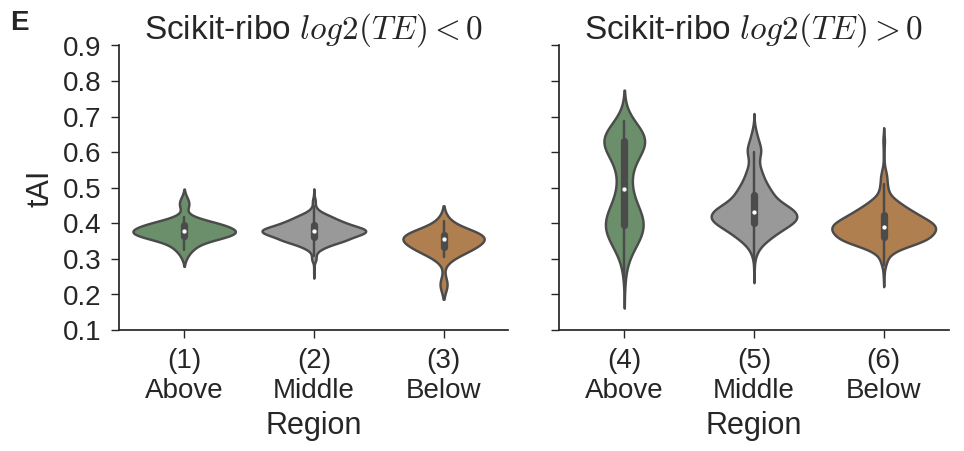

In [27]:
# plot Figure 4E violin plot
g = sns.FacetGrid(DFs["TE"][(DFs["TE"]["tpm_ribo"] > 10) & (DFs["TE"]["tpm_rna"] > 10)], 
                  col="skr_sign", size=5, sharex=False, col_order=["-", "+"])
g = g.map(sns.violinplot, "region", "tAI", order=regions, palette=colors)
g.axes[0,0].set_xticklabels(["(1)\nAbove","(2)\nMiddle", "(3)\nBelow"])
g.axes[0,1].set_xticklabels(["(4)\nAbove","(5)\nMiddle", "(6)\nBelow"])
g.axes[0,0].set_xlabel("Region")
g.axes[0,1].set_xlabel("Region")

for ax, title in zip(g.axes.flat, ['Scikit-ribo $log2(TE)<0$', 'Scikit-ribo $log2(TE)>0$']):
    ax.set_title(title)

g.axes[0,0].text(-1.2, 1.0, "E",  fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig("../Figures/Figure4E.pdf")

In [28]:
lm = ols('deltaTE ~ C(region)', data=DFs["TE"][(DFs["TE"]["skr_sign"]=="-")]).fit()
table =  sm.stats.anova_lm(lm)
# print(table)
for sign in ["+", "-"]:
    print("Scikit-ribo log2(TE) sign:", sign)
    for i in [("above","middle"),("middle", "below"),("above","below")]:
        l, r = i
        tmp = DFs["TE"][(DFs["TE"]["skr_sign"]==sign)&(DFs["TE"]["tpm_ribo"]>10) & (DFs["TE"]["tpm_rna"]>10)]
        a = tmp[tmp["region"] == l]["tAI"] 
        b = tmp[tmp["region"] == r]["tAI"] 
        p = ttest_ind(a,b)
        print(l, "VS.", r, "p-value:" ,p[1])
    print("\n")

Scikit-ribo log2(TE) sign: +
above VS. middle p-value: 1.61204341619e-17
middle VS. below p-value: 5.12099633924e-55
above VS. below p-value: 2.44077502895e-59


Scikit-ribo log2(TE) sign: -
above VS. middle p-value: 0.950207565451
middle VS. below p-value: 1.54329094798e-06
above VS. below p-value: 0.000299448289992




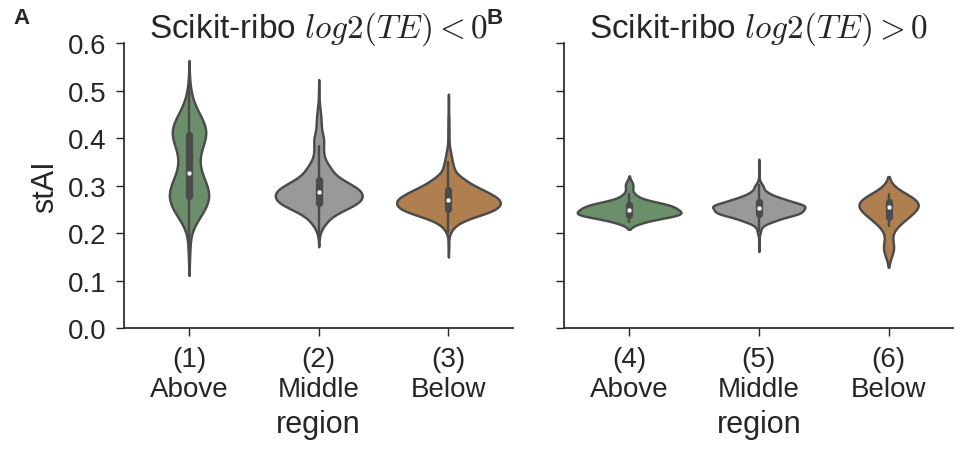

In [29]:
g = sns.FacetGrid(DFs["TE"][(DFs["TE"]["tpm_ribo"]>10) & (DFs["TE"]["tpm_rna"]>10)], 
                  col="skr_sign", size=5, sharex=False)
g = g.map(sns.violinplot, "region", "stAI", order=regions, palette=colors)
g.axes[0,0].set_xticklabels(["(1)\nAbove","(2)\nMiddle", "(3)\nBelow"])
g.axes[0,1].set_xticklabels(["(4)\nAbove","(5)\nMiddle", "(6)\nBelow"])
g.axes[0,0].text(-0.25, 1.7, "A", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
g.axes[0,1].text(1.25, 1.7, "B", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

for ax, title in zip(g.axes.flat, ['Scikit-ribo $log2(TE)<0$', 'Scikit-ribo $log2(TE)>0$']):
    ax.set_title(title)

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS5_stAI.pdf")

### 3. Validation with SRM data

In [30]:
skr_validation = pd.merge(DFs[skr_weinberg], DFs[kallisto_rna], left_on="gene", right_on="target_id")
skr_validation["log2_protein_skr"] = np.log2(skr_validation["tpm"]) + skr_validation["log2_TE"]

In [31]:
skr_validation = pd.merge(skr_validation, DFs[protein_quant], left_on="gene", right_on="protein")
skr_validation = pd.merge(skr_validation, DFs["TE"], on="gene")
print("Number of genes in the validation:", skr_validation.shape[0])
skr_validation["log2_protein_srm"] = np.log2(skr_validation["SRM_protein_quant"])
skr_validation_low = skr_validation[skr_validation["tpm"] < 100]
print(skr_validation[["SRM_protein_quant"]].describe())
print(skr_validation_low[["SRM_protein_quant"]].describe())

Number of genes in the validation: 1180
       SRM_protein_quant
count       1.180000e+03
mean        5.501186e+04
std         2.588056e+05
min         6.121785e+01
25%         1.414023e+03
50%         3.969283e+03
75%         2.004253e+04
max         4.366751e+06
       SRM_protein_quant
count         933.000000
mean        10834.294397
std         39383.000838
min            61.217854
25%          1098.225970
50%          2406.989346
75%          7414.300422
max        741968.813300


In [32]:
rpkm_validation = pd.merge(DFs[kallisto_ribo], DFs[protein_quant], left_on="target_id", right_on="protein")
rpkm_validation = pd.merge(rpkm_validation, DFs["TE"], how="left", left_on="target_id", right_on="gene")
rpkm_validation = rpkm_validation[rpkm_validation["tpm"] > 0] 
rpkm_validation["log2_protein_rpkm"] = np.log2(rpkm_validation["tpm"])
rpkm_validation["log2_protein_srm"] = np.log2(rpkm_validation["SRM_protein_quant"])
rpkm_validation_low = rpkm_validation[rpkm_validation["tpm"] < 100]

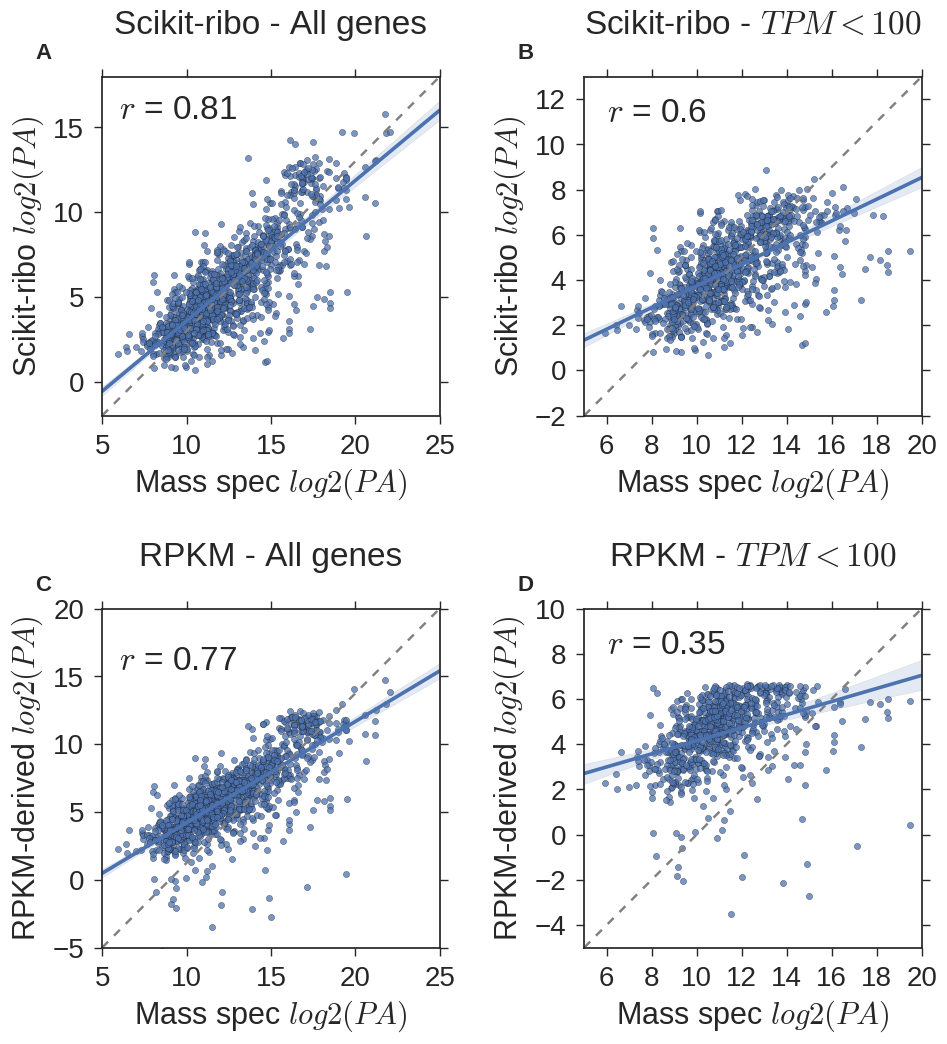

In [33]:
fig = plt.figure(figsize=(10, 11))

skr_srm_corr = round(pearsonr(skr_validation["log2_protein_srm"], skr_validation["log2_protein_skr"])[0] ,2)
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation, scatter=False)
plt.xlim(5,25)
plt.ylim(-2,18)
ax1.set_xlabel('Mass spec $log2(PA)$')
ax1.set_ylabel('Scikit-ribo $log2(PA)$')
ax1.text(6, 15.5, r"$r$ = " + str(skr_srm_corr))
ax1.text(-0.15, 1.1, "A", transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax1.plot([5,25], [-2,18], ls="dashed", color='gray')
ax1.set_title("Scikit-ribo - All genes\n")

skr_srm_low_corr = round(pearsonr(skr_validation_low["log2_protein_srm"], skr_validation_low["log2_protein_skr"])[0] ,2)
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation_low, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation_low, scatter=False)
plt.xlim(5,20)
plt.ylim(-2,13)
plt.xlabel('Mass spec $log2(PA)$')
plt.ylabel('Scikit-ribo $log2(PA)$')
ax2.text(6, 11, r"$r$ = " + str(skr_srm_low_corr))
ax2.text(-0.15, 1.1, "B", transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.plot([5,20], [-2,13], ls="dashed", color='gray')
ax2.set_title("Scikit-ribo - $TPM<100$\n")

rpkm_srm_corr = round(pearsonr(rpkm_validation["log2_protein_srm"], rpkm_validation["log2_protein_rpkm"])[0] ,2)
ax3 = plt.subplot(2, 2, 3)
ax3.scatter(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation, scatter=False)
plt.xlim(5,25)
plt.ylim(-5,20)
plt.xlabel('Mass spec $log2(PA)$')
plt.ylabel('RPKM-derived $log2(PA)$')
ax3.text(6, 15.5, r"$r$ = " + str(rpkm_srm_corr))
ax3.text(-0.15, 1.1, "C", transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.plot([5,25], [-5,20], ls="dashed", color='gray')
ax3.set_title("RPKM - All genes\n")

rpkm_srm_corr_low = round(pearsonr(rpkm_validation_low["log2_protein_srm"], 
                                   rpkm_validation_low["log2_protein_rpkm"])[0] ,2)
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation_low, alpha=0.75, edgecolor="k")
sns.regplot(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation_low, scatter=False)

plt.xlim(5,20)
plt.ylim(-5,10)
plt.xlabel('Mass spec $log2(PA)$')
plt.ylabel('RPKM-derived $log2(PA)$')
ax4.text(6, 8, r"$r$ = " + str(rpkm_srm_corr_low))
ax4.text(-0.15, 1.1, "D", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax4.plot([5,20], [-5,10], ls="dashed", color='gray')
ax4.set_title("RPKM - $TPM<100$\n")

plt.tight_layout()
plt.savefig("../Figures/Figure5_validation.pdf")

In [34]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='log2_protein_skr ~ log2_protein_srm', data=skr_validation)
results = mod.fit()
print("beta in A:", results.params[1])

mod = smf.ols(formula='log2_protein_skr ~ log2_protein_srm', data=skr_validation_low)
results = mod.fit()
print("beta in B:", results.params[1])

mod = smf.ols(formula='log2_protein_rpkm ~ log2_protein_srm', data=rpkm_validation)
results = mod.fit()
print("beta in C:", results.params[1])

mod = smf.ols(formula='log2_protein_rpkm ~ log2_protein_srm', data=rpkm_validation_low)
results = mod.fit()
print("beta in D:", results.params[1])

beta in A: 0.82876923264
beta in B: 0.479282420787
beta in C: 0.746104071901
beta in D: 0.28934403765


In [35]:
skr_validation = pd.merge(skr_validation, DFs[protein_degradation], on="gene")
skr_validation["log2_protein_skr_adj"] = np.log2(skr_validation["tpm"]) + skr_validation["log2_TE"] - \
                                         np.log2(skr_validation["protein_degradation"])  

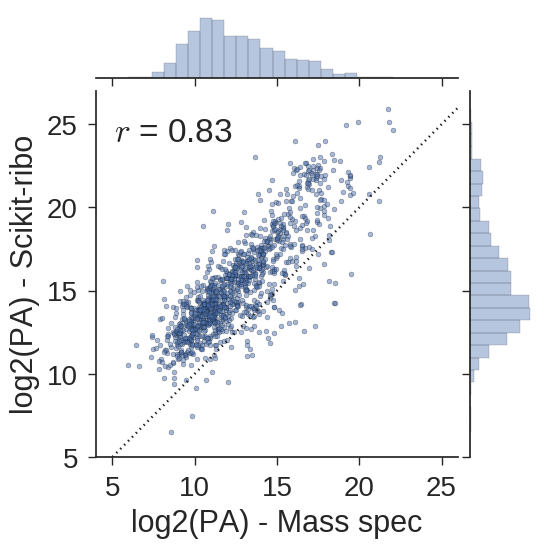

In [36]:
skr_srm_adj_corr = round(pearsonr(skr_validation["log2_protein_srm"], skr_validation["log2_protein_skr_adj"])[0] ,2)
g1 = sns.jointplot(x="log2_protein_srm", y="log2_protein_skr_adj", data=skr_validation, 
                   xlim= [4,26], ylim= [5,27], marker='.', s=50, alpha=0.5, stat_func=None,
                   edgecolor="black")
g1 = (g1.set_axis_labels("log2(PA) - Mass spec", "log2(PA) - Scikit-ribo"))

x0, x1 = g1.ax_joint.get_xlim()
y0, y1 = g1.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.ax_joint.plot(lims, lims, ':k')

plt.text(-800, 24, r"$r$ = " + str(skr_srm_adj_corr))
plt.savefig("../Figures/Supplemental/FigureS6_validation.pdf")